In [1]:
import matplotlib.pyplot as plt
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import sys
import cv2
# directory reach

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from support.ar_calculations import calculate_rotmat
from support.detect_lframe import detect_lframe_from_img

# from support.pymf import get_MF_devices as get_camera_list
import toml

In [2]:
_pth = toml.load("../analysis_notebooks/DATA_PATH.toml")["data_path"]["directory"]
_pth = os.path.dirname(_pth)
_parent_folder = "validation"
_folder_name = "calibration_00"
_parent_folder = "validation"

"""pth to calibration files"""
_pth = os.path.join(_pth, "recorded_data", _parent_folder, _folder_name)
_pth

'D:\\CMC\\DeepVision\\recorded_data\\validation\\calibration_00'

In [3]:
def calculate_rotmat_from_3markers(
    corners, ids, camera_matrix, dist_coeffs, marker_length=0.05
):
    rotation_vector, translation_vector, _ = cv2.aruco.estimatePoseSingleMarkers(
        corners, marker_length, camera_matrix, dist_coeffs
    )

    ids = list(ids)

    z_inx = ids.index(80)
    org_inx = ids.index(0)
    x_inx = ids.index(49)
    print(z_inx, org_inx, x_inx)

    zvec = translation_vector[z_inx][0]
    zvec = np.reshape(zvec, (3, 1))
    org = translation_vector[org_inx][0]
    org = np.reshape(org, (3, 1))
    xvec = translation_vector[x_inx][0]
    xvec = np.reshape(xvec, (3, 1))

    translation_vector
    zvec
    rotMat = calculate_rotmat(xvec, zvec, org)
    rotMat

    t_zvec = zvec - org
    t_xvec = xvec - org

    translation_correction = np.array([0.045, -0.05, 0.045]).reshape(
        3, 1
    )  # adding the corrections in the new L frame

    rotMat.T @ t_zvec + translation_correction
    # print(t_xvec)
    print(rotMat.T @ t_xvec)
    print(rotMat.T @ t_zvec)

    return rotMat, org

In [31]:
"""read image in msgpack format"""

_webcam_frame_file = os.path.join(_pth, "webcam_frame_validation_imu_7.msgpack")
with open(_webcam_frame_file, "rb") as f:
    unpacked = mp.Unpacker(f, object_hook=mpn.decode)
    for msg in unpacked:
        webcam_frame = msg

In [32]:
with open(os.path.join(_pth, "webcam_calibration.msgpack"), "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

In [33]:
"""for webcam calculating rotmat"""
corners, ids, _ = detect_lframe_from_img(webcam_frame)
w_rotmat, w_org = calculate_rotmat_from_3markers(
    corners,
    ids,
    marker_length=0.05,
    camera_matrix=_webcam_cam_mat,
    dist_coeffs=_webcam_dist,
)

1 0 2
[[ 1.51016571e-01]
 [-8.67361738e-19]
 [-2.77555756e-17]]
[[-1.03688731e-02]
 [-8.67361738e-19]
 [ 1.98106607e-01]]


In [42]:
rotation_vector, translation_vector, _ = cv2.aruco.estimatePoseSingleMarkers(
    corners, 0.05, _webcam_cam_mat, _webcam_dist
)
_image = cv2.cvtColor(webcam_frame, cv2.COLOR_GRAY2RGB)
_img = cv2.aruco.drawAxis(
    _image,
    _webcam_cam_mat,
    _webcam_dist,
    rotation_vector[0][0],
    translation_vector[0][0],
    0.05,
)
_img = cv2.aruco.drawAxis(
    _img,
    _webcam_cam_mat,
    _webcam_dist,
    rotation_vector[1][0],
    translation_vector[1][0],
    0.05,
)
_img = cv2.aruco.drawAxis(
    _img,
    _webcam_cam_mat,
    _webcam_dist,
    rotation_vector[2][0],
    translation_vector[2][0],
    0.05,
)
# show ids
_img = cv2.aruco.drawDetectedMarkers(_img, corners, ids)

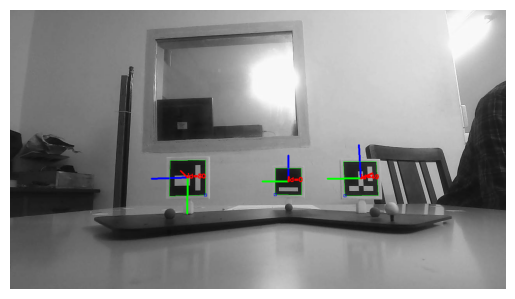

In [46]:
plt.imshow(_img, cmap="gray")
plt.axis("off")
plt.savefig("lframe.tiff", dpi=300, bbox_inches="tight")